In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# =========================
# 1) RAW DATA (side length in µm -> peak current in A)
# =========================
data = {
    "RT": {  # ~300 K
        "W20": {40: 0.020, 50: 0.033, 60: 0.043},
        "W21": {20: 0.00139, 35: 0.0043, 40: 0.0055, 50: 0.0085, 60: 0.011},
        "W22": {20: 0.00094, 30: 0.0024, 35: 0.0030, 40: 0.0040, 50: 0.0062, 60: 0.0090},
        "W65": {30: 0.017, 40: 0.023, 50: 0.035, 60: 0.046},
        "W67": {20: 0.00010, 30: 0.00028, 40: 0.00050, 50: 0.00080, 60: 0.00110},
    },
    "77K": {
        "W20": {40: 0.023, 50: 0.042, 60: 0.050},
        "W21": {35: 0.0076, 40: 0.0092, 60: 0.0190},
        "W22": {30: 0.0037, 35: 0.0041, 40: 0.0080, 50: 0.0090, 60: 0.0130},
        "W65": {30: 0.023, 40: 0.055, 50: 0.050, 60: 0.060},
        "W67": {20: 0.00017, 40: 0.00086, 50: 0.00130, 60: 0.00200},
    },
    "4.2K": {
        "W20": {},  # N/A
        "W21": {30: 0.0140},
        "W22": {30: 0.0076, 40: 0.0060, 50: 0.0082},
        "W65": {35: 0.0310},
        "W67": {20: 0.00023, 30: 0.00069, 40: 0.00120, 50: 0.00180, 60: 0.00260},
    }
}


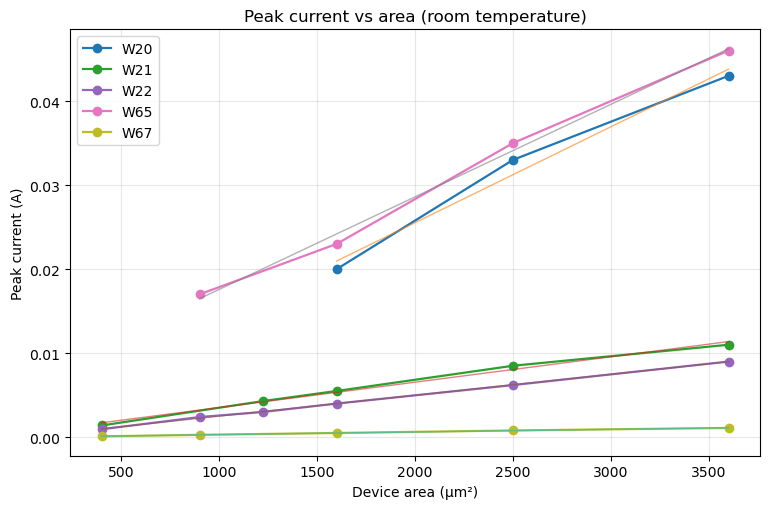

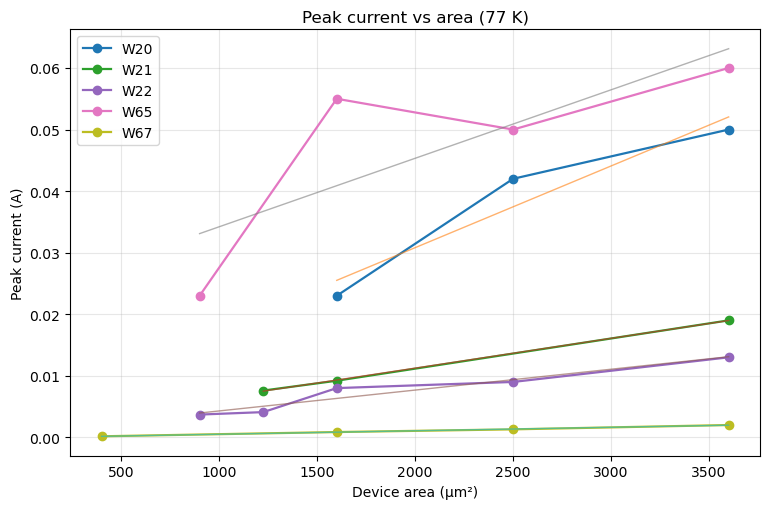

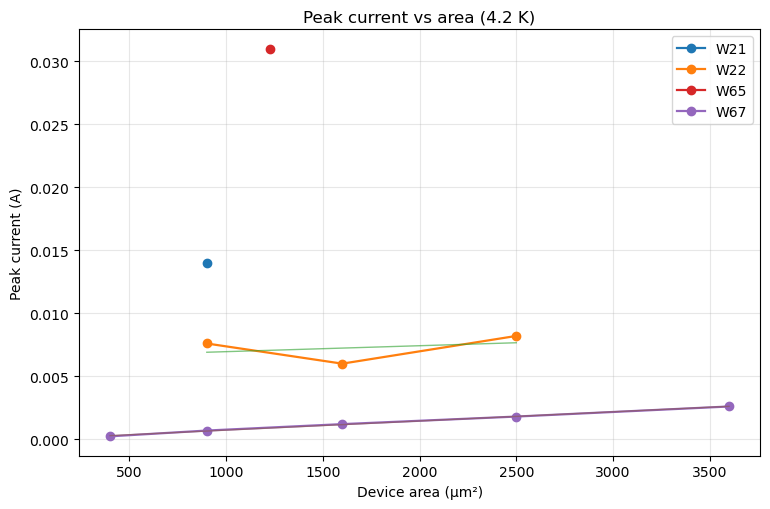

In [3]:

# =========================
# 2) HELPERS
# =========================
def chip_arrays(chip_dict):
    """
    Convert {side_um: I_peak_A, ...} -> (area_um2, I_peak_A) sorted by area.
    """
    if not chip_dict:
        return np.array([]), np.array([])
    sides = np.array(sorted(chip_dict.keys()), dtype=float)
    I = np.array([chip_dict[s] for s in sides], dtype=float)
    A = sides**2  # µm^2
    idx = np.argsort(A)
    return A[idx], I[idx]

def plot_temp(temp_key, title, ylim=None):
    plt.figure(figsize=(7.8, 5.2))
    for chip, d in data[temp_key].items():
        A, I = chip_arrays(d)
        if A.size == 0:
            continue
        plt.plot(A, I, marker="o", linewidth=1.6, label=chip)

        # Optional: linear fit line per chip (comment out if you don't want fits)
        if A.size >= 2:
            m, c = np.polyfit(A, I, 1)
            Afit = np.linspace(A.min(), A.max(), 100)
            plt.plot(Afit, m*Afit + c, linewidth=1.0, alpha=0.6)

    plt.xlabel("Device area (µm²)")
    plt.ylabel("Peak current (A)")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    if ylim is not None:
        plt.ylim(ylim)
    plt.legend()
    plt.tight_layout()

# =========================
# 3) MAKE THE 3 PLOTS (LINEAR AXES)
# =========================
plot_temp("RT",  "Peak current vs area (room temperature)")
plot_temp("77K", "Peak current vs area (77 K)")
plot_temp("4.2K","Peak current vs area (4.2 K)")

plt.show()

In [4]:
import numpy as np

def fit_J_through_origin(A, I):
    """
    Fit I = J*A through origin. Returns J_fit and diagnostics.
    """
    A = np.asarray(A, float)
    I = np.asarray(I, float)

    # Best-fit slope through origin: J = (A·I)/(A·A)
    J = (A @ I) / (A @ A)

    I_pred = J * A
    resid = I - I_pred

    # Percent errors relative to prediction (avoid divide-by-zero)
    pct_err = 100.0 * resid / np.where(I_pred != 0, I_pred, np.nan)

    # A simple R^2-like measure for through-origin fit
    ss_res = np.sum(resid**2)
    ss_tot = np.sum((I - np.mean(I))**2) if I.size >= 2 else np.nan
    r2 = 1.0 - ss_res/ss_tot if (I.size >= 2 and ss_tot != 0) else np.nan

    return {
        "J_fit": J,
        "I_pred": I_pred,
        "pct_err": pct_err,
        "max_abs_pct_err": np.nanmax(np.abs(pct_err)) if I.size else np.nan,
        "r2": r2,
        "J_each": I / A  # pointwise current density estimate
    }

def analyse_scaling(data):
    for temp, chips in data.items():
        print(f"\n=== {temp} ===")
        for chip, d in chips.items():
            if not d:
                print(f"{chip}: no data")
                continue

            sides = np.array(sorted(d.keys()), float)
            A = sides**2  # µm^2
            I = np.array([d[s] for s in sides], float)

            out = fit_J_through_origin(A, I)

            J_fit = out["J_fit"]
            J_each = out["J_each"]

            # How constant is I/A across sizes?
            mean_J = np.mean(J_each)
            std_J = np.std(J_each, ddof=1) if J_each.size >= 2 else 0.0
            cv = std_J/mean_J if mean_J != 0 else np.nan  # coefficient of variation

            print(
                f"{chip}: n={len(A)}  "
                f"J_fit={J_fit:.4e} A/µm²  "
                f"mean(I/A)={mean_J:.4e}  "
                f"CV={cv:.3f}  "
                f"max|%err|={out['max_abs_pct_err']:.1f}%  "
                f"R2={out['r2'] if not np.isnan(out['r2']) else 'NA'}"
            )

# Run it:
analyse_scaling(data)


=== RT ===
W20: n=3  J_fit=1.2370e-05 A/µm²  mean(I/A)=1.2548e-05  CV=0.050  max|%err|=6.7%  R2=0.9748273992284339
W21: n=5  J_fit=3.2211e-06 A/µm²  mean(I/A)=3.3757e-06  CV=0.054  max|%err|=9.0%  R2=0.9854029354014234
W22: n=6  J_fit=2.4963e-06 A/µm²  mean(I/A)=2.4909e-06  CV=0.041  max|%err|=6.8%  R2=0.9992407558253116
W65: n=4  J_fit=1.3516e-05 A/µm²  mean(I/A)=1.5010e-05  CV=0.178  max|%err|=39.7%  R2=0.9322327075438818
W67: n=5  J_fit=3.1011e-07 A/µm²  mean(I/A)=2.9983e-07  CV=0.094  max|%err|=19.4%  R2=0.9977070843812653

=== 77K ===
W20: n=3  J_fit=1.4782e-05 A/µm²  mean(I/A)=1.5021e-05  CV=0.104  max|%err|=13.7%  R2=0.9058572009721932
W21: n=3  J_fit=5.4305e-06 A/µm²  mean(I/A)=5.7440e-06  CV=0.081  max|%err|=14.2%  R2=0.9808152481211253
W22: n=5  J_fit=3.7562e-06 A/µm²  mean(I/A)=3.9338e-06  CV=0.167  max|%err|=33.1%  R2=0.9193096990776767
W65: n=4  J_fit=1.9916e-05 A/µm²  mean(I/A)=2.4149e-05  CV=0.321  max|%err|=72.6%  R2=0.14689471393209896
W67: n=4  J_fit=5.4236e-07 A/µm²

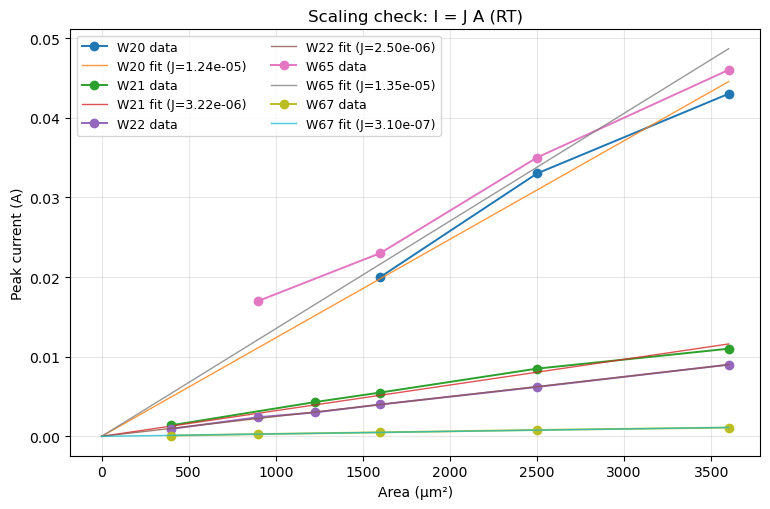

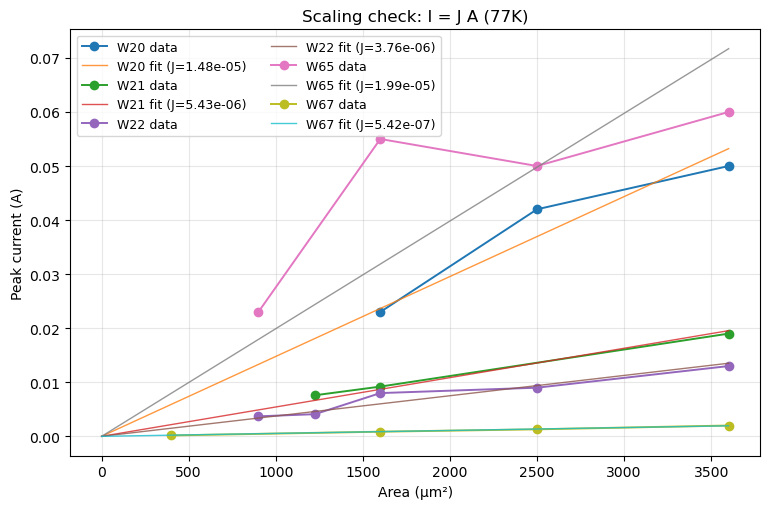

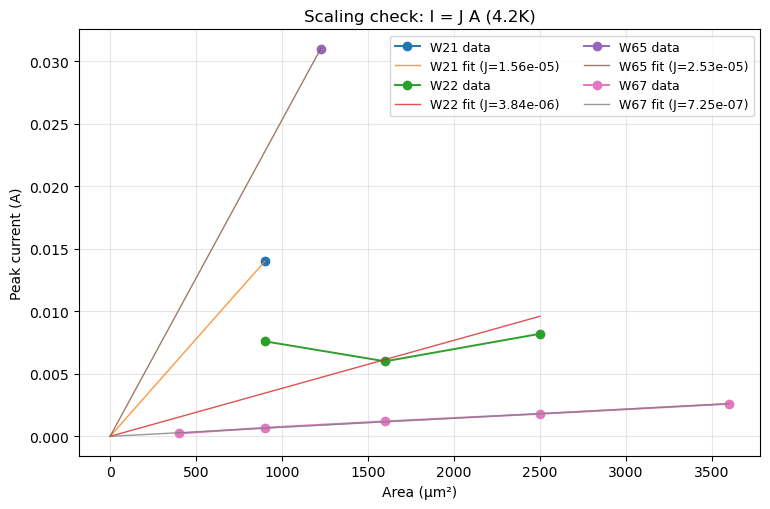

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_scaling_check(temp_key):
    plt.figure(figsize=(7.8, 5.2))
    for chip, d in data[temp_key].items():
        if not d:
            continue
        sides = np.array(sorted(d.keys()), float)
        A = sides**2
        I = np.array([d[s] for s in sides], float)

        out = fit_J_through_origin(A, I)
        J = out["J_fit"]

        plt.plot(A, I, marker="o", linewidth=1.4, label=f"{chip} data")

        Aline = np.linspace(0, A.max(), 100)
        plt.plot(Aline, J*Aline, linewidth=1.0, alpha=0.8, label=f"{chip} fit (J={J:.2e})")

    plt.xlabel("Area (µm²)")
    plt.ylabel("Peak current (A)")
    plt.title(f"Scaling check: I = J A ({temp_key})")
    plt.grid(True, alpha=0.3)
    plt.legend(ncol=2, fontsize=9)
    plt.tight_layout()
    plt.show()

plot_scaling_check("RT")
plot_scaling_check("77K")
plot_scaling_check("4.2K")

In [6]:
# =========================
# DROP-IN: standard linear regression per chip on each temperature plot
# (prints gradient, intercept, R^2 for I = m*A + c)
# Assumes your `data` dict exists and A is in µm^2, I in A
# =========================

def linregress_basic(x, y):
    """
    Ordinary least squares for y = m x + c.
    Returns m, c, R^2.
    """
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    if x.size < 2:
        return np.nan, np.nan, np.nan

    m, c = np.polyfit(x, y, 1)
    yhat = m*x + c

    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r2 = np.nan if ss_tot == 0 else 1.0 - ss_res/ss_tot
    return m, c, r2

print("\n==== OLS fits: I = m*A + c (A in µm², I in A) ====")
for temp_key, chips in data.items():
    print(f"\n--- {temp_key} ---")
    for chip, d in chips.items():
        if not d or len(d) < 2:
            print(f"{chip}: not enough points for regression")
            continue

        sides = np.array(sorted(d.keys()), float)
        A = sides**2  # µm^2
        I = np.array([d[s] for s in sides], float)

        m, c, r2 = linregress_basic(A, I)
        print(f"{chip}: m={m:.4e} A/µm², c={c:.4e} A, R²={r2:.4f}")


==== OLS fits: I = m*A + c (A in µm², I in A) ====

--- RT ---
W20: m=1.1412e-05 A/µm², c=2.7093e-03 A, R²=0.9825
W21: m=3.0196e-06 A/µm², c=5.0652e-04 A, R²=0.9914
W22: m=2.4923e-06 A/µm², c=9.3069e-06 A, R²=0.9992
W65: m=1.1015e-05 A/µm², c=6.5685e-03 A, R²=0.9949
W67: m=3.1315e-07 A/µm², c=-7.6697e-06 A, R²=0.9978

--- 77K ---
W20: m=1.3272e-05 A/µm², c=4.2674e-03 A, R²=0.9189
W21: m=4.8332e-06 A/µm², c=1.5822e-03 A, R²=0.9997
W22: m=3.3879e-06 A/µm², c=9.0279e-04 A, R²=0.9331
W65: m=1.1125e-05 A/µm², c=2.3082e-02 A, R²=0.6188
W67: m=5.6549e-07 A/µm², c=-6.2619e-05 A, R²=0.9979

--- 4.2K ---
W20: not enough points for regression
W21: not enough points for regression
W22: m=4.7150e-07 A/µm², c=6.4808e-03 A, R²=0.1106
W65: not enough points for regression
W67: m=7.2737e-07 A/µm², c=-5.2661e-06 A, R²=0.9980


In [7]:
import numpy as np

def fit_origin(A, I):
    A = np.asarray(A, float); I = np.asarray(I, float)
    J = (A @ I) / (A @ A)
    I_hat = J*A
    return J, I_hat

def fit_ols(A, I):
    A = np.asarray(A, float); I = np.asarray(I, float)
    m, c = np.polyfit(A, I, 1)
    I_hat = m*A + c
    ss_res = np.sum((I - I_hat)**2)
    ss_tot = np.sum((I - np.mean(I))**2)
    r2 = np.nan if ss_tot == 0 else 1 - ss_res/ss_tot
    return m, c, r2, I_hat

print("\n=== Compare origin-fit vs OLS: I = J*A  vs  I = m*A + c ===")
for temp, chips in data.items():
    print(f"\n--- {temp} ---")
    for chip, d in chips.items():
        if not d or len(d) < 2:
            continue
        sides = np.array(sorted(d.keys()), float)
        A = sides**2
        I = np.array([d[s] for s in sides], float)

        J, I0 = fit_origin(A, I)
        m, c, r2, I1 = fit_ols(A, I)

        # how big is c compared to typical currents?
        c_frac = np.abs(c) / np.mean(np.abs(I))

        print(f"{chip}: J(origin)={J:.3e}  |  m(OLS)={m:.3e}, c={c:.3e}, R²={r2:.4f}, |c|/mean(I)={c_frac:.2f}")


=== Compare origin-fit vs OLS: I = J*A  vs  I = m*A + c ===

--- RT ---
W20: J(origin)=1.237e-05  |  m(OLS)=1.141e-05, c=2.709e-03, R²=0.9825, |c|/mean(I)=0.08
W21: J(origin)=3.221e-06  |  m(OLS)=3.020e-06, c=5.065e-04, R²=0.9914, |c|/mean(I)=0.08
W22: J(origin)=2.496e-06  |  m(OLS)=2.492e-06, c=9.307e-06, R²=0.9992, |c|/mean(I)=0.00
W65: J(origin)=1.352e-05  |  m(OLS)=1.101e-05, c=6.568e-03, R²=0.9949, |c|/mean(I)=0.22
W67: J(origin)=3.101e-07  |  m(OLS)=3.131e-07, c=-7.670e-06, R²=0.9978, |c|/mean(I)=0.01

--- 77K ---
W20: J(origin)=1.478e-05  |  m(OLS)=1.327e-05, c=4.267e-03, R²=0.9189, |c|/mean(I)=0.11
W21: J(origin)=5.430e-06  |  m(OLS)=4.833e-06, c=1.582e-03, R²=0.9997, |c|/mean(I)=0.13
W22: J(origin)=3.756e-06  |  m(OLS)=3.388e-06, c=9.028e-04, R²=0.9331, |c|/mean(I)=0.12
W65: J(origin)=1.992e-05  |  m(OLS)=1.112e-05, c=2.308e-02, R²=0.6188, |c|/mean(I)=0.49
W67: J(origin)=5.424e-07  |  m(OLS)=5.655e-07, c=-6.262e-05, R²=0.9979, |c|/mean(I)=0.06

--- 4.2K ---
W22: J(origin)=3.8

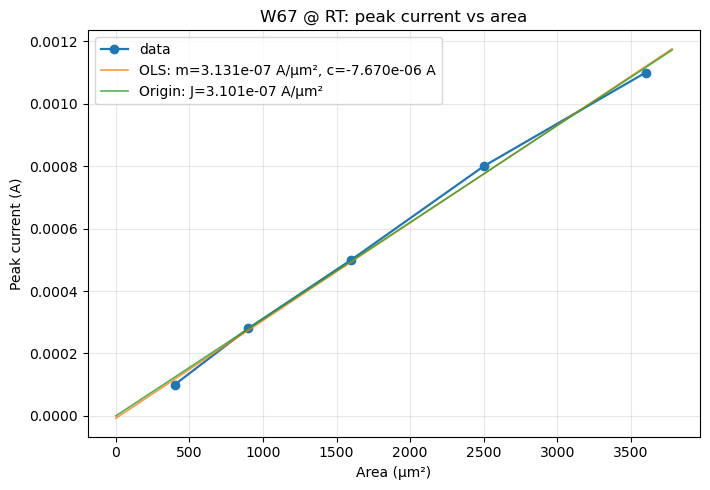

In [8]:
# =========================
# DROP-IN: plot ONE chosen chip at ONE chosen temperature (linear axes)
# Assumes your `data` dict already exists.
# =========================

# ---- choose these ----
CHIP_TO_PLOT = "W67"     # e.g. "W20", "W21", "W22", "W65", "W67"
TEMP_TO_PLOT = "RT"      # "RT", "77K", or "4.2K"

import numpy as np
import matplotlib.pyplot as plt

d = data.get(TEMP_TO_PLOT, {}).get(CHIP_TO_PLOT, {})
if not d:
    print(f"No data for {CHIP_TO_PLOT} at {TEMP_TO_PLOT}")
else:
    sides = np.array(sorted(d.keys()), float)
    A = sides**2  # µm^2
    I = np.array([d[s] for s in sides], float)

    # Standard OLS: I = m*A + c
    m, c = np.polyfit(A, I, 1)
    I_ols = m*A + c

    # Through-origin fit: I = J*A
    J = (A @ I) / (A @ A)
    I0 = J*A

    # Plot
    plt.figure(figsize=(7.2, 5.0))
    plt.plot(A, I, "o-", linewidth=1.6, label="data")

    Aline = np.linspace(0, A.max()*1.05, 200)
    plt.plot(Aline, m*Aline + c, linewidth=1.2, alpha=0.8,
             label=f"OLS: m={m:.3e} A/µm², c={c:.3e} A")
    plt.plot(Aline, J*Aline, linewidth=1.2, alpha=0.8,
             label=f"Origin: J={J:.3e} A/µm²")

    plt.xlabel("Area (µm²)")
    plt.ylabel("Peak current (A)")
    plt.title(f"{CHIP_TO_PLOT} @ {TEMP_TO_PLOT}: peak current vs area")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()